
# Pakistan's Largest E-Commerce Dataset 
datset link: https://www.kaggle.com/datasets/zusmani/pakistans-largest-ecommerce-dataset 

The typical Machine Learning pipeline includes the following: 

1. Data Preparation - obtaining and loading the data.
2. Data Preprocessing - cleaning the data (missing values, etc).
3. Exploratory Data Analysis (EDA) - generating summaries and utilizing other statistical methods, and visualizing the data. 
4. Data Processing - feature selection/extraction and feature engineering.
5. Building a Model - splitting data into training and testing sets (holdout - optional), and training and testing chosen machine learning algorithms.
6. Model Evaluation - choosing metrics, applying metrics on predictions on the testing set, selecting the best model in your opinion.

In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import pyspark
from pyspark.sql import functions as F
from pyspark.sql import types

from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



#### Connect to the Spark server

We will be using the SparkSession (`spark`) to access our spark cluster..

In [4]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()


## 1. Data Preparation

The data has been made available to us in the `data` directory

In [5]:
fullpath = '/content/drive/MyDrive/Colab Notebooks/Big_data/w10/day_2/Pakistan Largest Ecommerce Dataset.csv'

data = spark.read.csv(fullpath)

In [6]:
data

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string, _c21: string, _c22: string, _c23: string, _c24: string, _c25: string]

In [7]:
# read.csv is very similar to the Pandas version
data = spark.read.csv(fullpath,
                     sep=',',
                     inferSchema=True,
                     header=True,
                     multiLine=True)

data.printSchema()

root
 |-- item_id: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- sku: string (nullable = true)
 |-- price: double (nullable = true)
 |-- qty_ordered: integer (nullable = true)
 |-- grand_total: double (nullable = true)
 |-- increment_id: string (nullable = true)
 |-- category_name_1: string (nullable = true)
 |-- sales_commission_code: string (nullable = true)
 |-- discount_amount: double (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- Working Date: string (nullable = true)
 |-- BI Status: string (nullable = true)
 |--  MV : string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Customer Since: string (nullable = true)
 |-- M-Y: string (nullable = true)
 |-- FY: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string

## 2. Data Preprocessing



In [8]:
#check the content of the column 
data.select("_c21").show(10)


+----+
|_c21|
+----+
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
|null|
+----+
only showing top 10 rows



In [9]:
# these columns are useless to us, drop them
drop_cols = ['item_id', 'created_at', 'increment_id', 'sales_commission_code','_c21','_c22','_c23','_c24','_c25']

data = data.drop(*drop_cols)

## 3. Exploratory Data Analysis (EDA)

In [10]:
data.select('price', 'Year').summary().show()

+-------+------------------+------------------+
|summary|             price|              Year|
+-------+------------------+------------------+
|  count|            584524|            584524|
|   mean| 6348.747531033922|2017.0441145273762|
| stddev|14949.269515296823|0.7073546844960852|
|    min|               0.0|              2016|
|    25%|             360.0|              2017|
|    50%|            899.25|              2017|
|    75%|            4070.0|              2018|
|    max|         1012625.9|              2018|
+-------+------------------+------------------+



In [11]:
data.registerTempTable('data')

state_counts = spark.sql(r"""SELECT payment_method ,price 
                                     FROM data """)
state_counts.show()

+--------------+-------+
|payment_method|  price|
+--------------+-------+
|           cod| 1950.0|
|           cod|  240.0|
|           cod| 2450.0|
|           cod|  360.0|
|           cod|  555.0|
|           cod|   80.0|
|           cod|  360.0|
|           cod|  170.0|
| ublcreditcard|96499.0|
|     mygateway|96499.0|
|           cod| 5500.0|
|           cod|  210.0|
|           cod|  156.0|
| ublcreditcard|  120.0|
|customercredit|  320.0|
| ublcreditcard| 1550.0|
|           cod|  420.0|
|           cod|  360.0|
|           cod|  490.0|
|           cod| 899.25|
+--------------+-------+
only showing top 20 rows



In [12]:
df_result = spark.sql('SELECT payment_method ,price FROM data WHERE payment_method IN ("cod","bankalfalah")')

#convert to pandas prior to visualization
df_result = df_result.toPandas()

In [ ]:
sns.set_context("notebook", font_scale=1.25)
sns.histplot(data=df_result, x='price', hue='payment_method', binwidth=0.3)

In [ ]:
df_result = spark.sql('SELECT status FROM data')
df_result = df_result.toPandas()

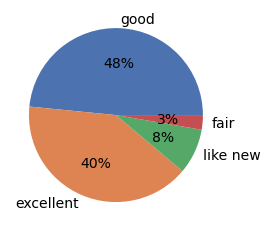

In [ ]:
df_result_c = df_result['status'].value_counts().nlargest(4)
colors = sns.color_palette('deep')

plt.pie(df_result_c.values, labels=df_result_c.index, colors=colors, autopct='%.0f%%', textprops={'fontsize': 14})
plt.show()

## Data Preparation for ML

### Imputation

On Numeric Columns, we will replace the missing values using the mean of each column.

In [13]:
num_cols = ['qty_ordered', 'price', 'grand_total']

imputer = Imputer(inputCols=num_cols, outputCols=num_cols, strategy='mean')
model = imputer.fit(data)
data = model.transform(data)

On Categorical Columns, we will replace the missing values with 'unknown'.

In [14]:
cat_cols = ['payment_method']

In [15]:
data = data.fillna('unknown', subset=cat_cols)

Then we will encode all the categorical columns using StringIndexer and drop the original columns.

In [16]:
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_idx')
    data = indexer.fit(data).transform(data)
    
data = data.drop(*cat_cols)

### Combining Feature Columns

Inputs to Scikit-learn models have the data split into X-arrays/dataframes (features) and Y-arrays/dataframes (predictors). PySpark expects both the features and the predictor to be in a single dataframe. However, all the features have to be combined into a single column containing a list of the feature values. To accomplish this, we use [`VectorAssembler`](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler).

Note that VectorAssembler uses transform. This is just like the second step of Scikit-learn's feature transformers for normalization, etc.

In [28]:
#arg = ['qty_ordered','payment_method', 'grand_total']


In [17]:
cols = data.columns
to_drop_list =['status',
 'sku',
 'category_name_1',
 'discount_amount',
 'Working Date',
 'BI Status',
 ' MV ',
 'Year',
 'Month',
 'Customer Since',
 'M-Y',
 'FY',
 'Customer ID',
 'price']

for i in to_drop_list:
    cols.remove(i)

In [18]:
cols

['qty_ordered', 'grand_total', 'payment_method_idx']

In [23]:
assembler = VectorAssembler(inputCols=cols, outputCol='features')

data = assembler.transform(data)

### Set columns and Split

Before modelling, the data are split into train and test data sets. We will make the train set bigger at this point as will incorporate cross validation later on.

In [24]:
# We have created a new dataframe only consisting of the features column and the label column (actually price column but renamed)
df_data = data.select(F.col('features'), F.col('price').alias('label'))

df_train, df_test = df_data.randomSplit([0.8, 0.2])

## Model Building


### Initialize Evaluator and Grid
As we are dealing with continuous values, we will be using Regressors to be trained on the data and then be used in prediction. Accordingly, we will have to use Regression Evaluator to evaluate all the Regressors we will be using.

In [25]:
evaluator = RegressionEvaluator() # Can specify what metrics we want to use. Default metric is Root Mean Squared Error (RMSE)
grid = ParamGridBuilder().build()

### Initialize Regressors and Train

Now we get to the fun part--machine learning! 

PySpark has two machine learning libraries:

1. MLlib: older, based on RDDs, more complete, but no additional features are being added as of Spark 2.0
2. ML: the *future*, based on DataFrames, less feature complete than MLlib but this is improving

Often the name MLlib is used to refer to both libraries, so context is important and this can be confusing. We will be using ML whenever possible.

We will use Random Forest Regressor, Gradient Boosted Trees Regressor, Decision Tree Regressor, and Linear Regression. We will also be using cross validation as mentioned earlier with 5 folds (you can adjust this number).

We will begin by training a number of models and evaluating the results. Notice that the `fit` method is similar to Scikit-learn. However, `transform` is used with PySpark instead of `predict`. The syntax is similar among different PySpark ML models, though.

In [26]:
#Random Forest Regressor
classifier_rf = RandomForestRegressor(featuresCol='features', labelCol='label')
cv_rf = CrossValidator(estimator=classifier_rf, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_rf = cv_rf.fit(df_train)

In [27]:
#Gradient Boosted Tree Regressor
classifier_gbt = GBTRegressor(featuresCol="features", labelCol='label', maxIter=10)
cv_gbt = CrossValidator(estimator=classifier_gbt, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_gbt = cv_gbt.fit(df_train)

In [28]:
#Decision Tree Regressor
classifier_dt = DecisionTreeRegressor(featuresCol="features", labelCol='label')
cv_dt = CrossValidator(estimator=classifier_dt, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_dt = cv_dt.fit(df_train)

In [29]:
#Linear Regression
classifier_lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
cv_lr = CrossValidator(estimator=classifier_lr, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_lr = cv_lr.fit(df_train)

### Evaluation

We will now get the average metrics of all models created by the regressors in the last step. And we will use the best model from each of the cross validated regressors to make predictions on the testing set. Lastly, this will all be presented in a dataframe for us to compare.

In [30]:
metrics = []
models = [cv_model_rf, cv_model_gbt, cv_model_dt, cv_model_lr]

for model in models:
    metrics.append(model.avgMetrics)
print (metrics)

for idx, model in enumerate(models): 
    metrics[idx].append(RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='r2').evaluate(model.bestModel.transform(df_test)))
    metrics[idx].append(RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse').evaluate(model.bestModel.transform(df_test)))
    metrics[idx].append(RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='mae').evaluate(model.bestModel.transform(df_test)))

df = pd.DataFrame(metrics, index = ['Random Forest Regressor', 'Gradient Boosted Tree Regressor', 'Decision Tree Regressor', 'Linear Regression'], columns=['Average Metrics (CV)', 'Best Model R2 on Test Set', 'Best Model RMSE on Test Set', 'Best Model MAE on Test Set'])

df

[[6503.976224956925], [5833.642607547048], [5798.309666391486], [10077.678748468092]]


,Average Metrics (CV),Best Model R2 on Test Set,Best Model RMSE on Test Set,Best Model MAE on Test Set
Random Forest Regressor,6503.976225,0.682931,6235.224706,2232.472575
Gradient Boosted Tree Regressor,5833.642608,0.744315,5599.227011,1445.759383
Decision Tree Regressor,5798.309666,0.746838,5571.537519,1495.868324
Linear Regression,10077.678748,0.219302,9784.012544,4311.029963


For further reading on PySpark classification and regression follow this link: https://spark.apache.org/docs/latest/ml-classification-regression.html